In [1]:
# TF import error "AttributeError: module 'wrapt' has no attribute 'ObjectProxy'"" has to be solved by installing older wrapt version 1.11.1
# pip install wrapt==1.11.1

import tensorflow as tf
# print(tf.__version__)
import tensorflow_hub as hub

# Need to install tensorflow-text to be able to import
# Use --user to prevent access denied error during installation
# pip install --user tensorflow-text

# tensorflow_text not working with tf 2.8.0 so install TF 2.10.0 and use --user to prevent access denied error
# pip install --user tensorflow==2.10.0

import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
# Find %age distribution of categories
print (df['Category'][1], round(100*df['Category'].value_counts()[0]/(df['Category'].value_counts()[0]+df['Category'].value_counts()[1]),2),'%')
print (df['Category'][2], round(100*df['Category'].value_counts()[1]/(df['Category'].value_counts()[0]+df['Category'].value_counts()[1]),2),'%')

ham 86.59 %
spam 13.41 %


In [6]:
# Clear class imbalance observed. For now, attempt downsampling.
#Create DFs for each category
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
#Pass the desired downsampled size to sample function which is called on the DF that needs to be downsampled
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

#We now have equal no. of ham and spam emails

(747, 2)

In [9]:
# Create a new DF to store complete final data
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
2463,ham,"Rose needs water, season needs change, poet ne..."
3499,ham,You said to me before i went back to bed that ...
3704,ham,How is my boy? No sweet words left for me this...
2093,ham,"Oh, my love, it's soooo good to hear from you...."


In [10]:
#Confirm category counts
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [11]:
# Perform label encoding for nominal category column (1 for spam mails, 0 for ham mails). Add a column called "Category_num" to the DF, containing the resulting column
df_balanced['Category_num']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,Category_num
4258,spam,important information 4 orange user . today is...,1
3094,ham,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323,0
416,ham,Whatsup there. Dont u want to sleep,0
2381,ham,"If i let you do this, i want you in the house ...",0
1246,ham,Hello which the site to download songs its urg...,0


## Split into train and test dataset

In [12]:
from sklearn.model_selection import train_test_split
# Opt for stratified sampling so that there is equal distribution of ham&spam mails in each dataset
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['Category_num'], stratify=df_balanced['Category_num'])


In [13]:
X_train.head(5)

3954    Refused a loan? Secured or Unsecured? Can't ge...
3443    Save money on wedding lingerie at www.bridal.p...
2851    She's fine. Good to hear from you. How are you...
862                              Your brother is a genius
1384    Please reserve ticket on saturday eve from che...
Name: Message, dtype: object

### Importing BERT model and creating embedded vectors for sample statements

In [14]:
# Faced "FileNotFoundError: Op type not registered 'CaseFoldUTF8' ..." while trying to use tensorflow_hub. So uninstalled it using below statement, restarted kernel, and now imported tensorflow_hub can be used without error
# pip uninstall --user tensorflow_hub

#Using pretrained BERT preprocessing and encoder models available via TensorFlow
bert_preprocessing_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [15]:
# Function to generate sentence embedding by applying preprocessing to text (sentences) and obtaining encoded representation of preprocessed text
# The overall encoded representation output is in the form of a tensor.
# In this, where there is vector embedding for each sentence, of 768 dimensions (no. of dimensions offered by the pretrained models)
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocessing_model(sentences)
    return bert_encoder_model(preprocessed_text)['pooled_output']

get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleyball game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132727 , -0.8884573 , ..., -0.7474888 ,
        -0.7531474 ,  0.91964483],
       [-0.8205971 , -0.5209497 , -0.9524537 , ..., -0.8804193 ,
        -0.70536864,  0.8252004 ]], dtype=float32)>

### Get embedding vectors for a few sample words. Compare them using cosine similarity

In [16]:
e= get_sentence_embedding([

    'Kia', 'Tata', 'Mahindra', 'Toyota', 'Hyundai', 
    'Apples','Oranges','Noodles','Lemons','Papaya'
    #'Canada', 'France', 'Germany', 'Italy', 'USA'
])

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[4]])

array([[0.9784125]], dtype=float32)

In [18]:
cosine_similarity([e[0]],[e[8]])

array([[0.9719338]], dtype=float32)

Cosine similarities aren't significantly different for diff categories (car manufacturers vs country names/ car manufacturers vs food items) in above samples. 


## Building BERT model for email data

In [19]:
# BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessing_model(text_input)
outputs = bert_encoder_model(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

### Training the model on training data

In [22]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 256s 7s/step - loss: 0.6818 - accuracy: 0.5723 - precision: 0.5730 - recall: 0.5679
Epoch 2/10
35/35 [==============================] - 293s 8s/step - loss: 0.5460 - accuracy: 0.7786 - precision: 0.7943 - recall: 0.7518
Epoch 3/10
35/35 [==============================] - 248s 7s/step - loss: 0.4663 - accuracy: 0.8116 - precision: 0.7963 - recall: 0.8375
Epoch 4/10
35/35 [==============================] - 275s 8s/step - loss: 0.4223 - accuracy: 0.8518 - precision: 0.8420 - recall: 0.8661
Epoch 5/10
35/35 [==============================] - 267s 8s/step - loss: 0.3786 - accuracy: 0.8884 - precision: 0.8744 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 255s 7s/step - loss: 0.3486 - accuracy: 0.8911 - precision: 0.8763 - recall: 0.9107
Epoch 7/10
35/35 [==============================] - 230s 7s/step - loss: 0.3431 - accuracy: 0.8857 - precision: 0.8661 - recall: 0.9125
Epoch 8/10
35/35 [==============================

In [23]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 118s 9s/step - loss: 0.2852 - accuracy: 0.9091 - precision: 0.8923 - recall: 0.9305


[0.2852230370044708, 0.9090909361839294, 0.892307698726654, 0.9304812550544739]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 157s 13s/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[166,  21],
       [ 13, 174]], dtype=int64)

Text(33.0, 0.5, 'Truth')

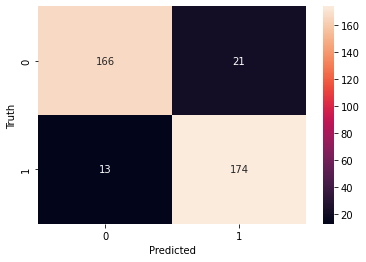

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       187
           1       0.89      0.93      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



So, we have 93% accuracy in identification of ham mails and 89% accuracy in identification of spam mails through this model.

Now, we can try using this model on a new set of unseen emails.

In [29]:
mails= [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(mails)

1/1 [==============================] - 5s 5s/step


array([[0.7046607 ],
       [0.7820445 ],
       [0.73778135],
       [0.22749726],
       [0.11840627]], dtype=float32)

### Interpretation of result

The first 3 emails are spammy, which is why the model returns a value >0.5 (greater than 0.5 means its 1, i.e. spam acc to model).
The last 2 emails seem more like ham mails, and the model confirms this by returning a value<0.5 (indicating ham mail)